# Time Series Analysis with SARIMAX


Here we analyze 4 years of hourly energy consumption to find trends in energy consumption around hour of the day, day of the week, season of the year, etc. and also to examine factors like outside temperature and solar installations. The goal is to build to predict the energy consumption given parameters like day of the week, time of the day, season, holiday, local weather, solar installation, etc.

The energy consumption values can also be expected to depend on it’s previous lagged values because the energy consumption of a region shouldn’t be expected to change much in the next few hours except for any unexpected or unfortunate events. So we will add the lagged values of energy consumption as the X parameters and check if we can predict better using the past values (in addition to the variables that we had already added).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from green_city.utils import span
from green_city.utils import datetime2index, index2datetime
from green_city.plotting import plot_decomposition

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [7]:
building_nr = 5
column_to_predict = "net_load_kW"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building nr": building_nr,
    "predicted feature": column_to_predict,
    "resolution": "daily",
}

In [8]:
# Set to True to record values in mlflow and SQL database
write_data = False

In [9]:
if write_data:
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))

    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)


In [10]:
# Load data
df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [11]:
df.head()

,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kW,dhw_heating_kW,cooling_load_kW,solar_generation_W_kW,outdoor_temp,outdoor_hum,...,pred_12h_diffuse_solar_W_m2,pred_24h_diffuse_solar_W_m2,pred_6h_direct_solar_W_m2,pred_12h_direct_solar_W_m2,pred_24h_direct_solar_W_m2,holiday,workday,solar_generation_kW,electric_load_hp_kW,net_load_kW
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,0,22.02,0.0,55.86,11.7,3.00,1.61,0.0,9.40,94.12,...,170.84,0.0,-0.00,5.32,0.0,True,False,0.0,0.170,14.870
2008-01-02 01:00:00,0,21.78,0.0,52.90,7.2,3.36,0.47,0.0,7.61,93.00,...,112.24,0.0,1.11,2.04,-0.0,True,False,0.0,0.029,10.589
2008-01-02 02:00:00,0,21.77,0.0,50.06,8.1,0.36,0.58,0.0,8.11,93.00,...,65.93,0.0,1.74,1.04,0.0,True,False,0.0,0.043,8.503
2008-01-02 03:00:00,0,21.81,0.0,47.95,12.4,0.12,1.19,0.0,8.36,93.00,...,38.59,-0.0,1.09,0.99,0.0,True,False,0.0,0.096,12.616
2008-01-02 04:00:00,0,21.77,0.0,46.91,8.6,0.00,0.59,0.0,8.78,93.00,...,15.92,0.0,1.78,0.84,0.0,True,False,0.0,0.053,8.653


In [12]:
y = df['net_load_kW']
df_train = df[['net_load_kW']].iloc[:(len(df)-365*24)]
df_test = df[['net_load_kW']].iloc[(len(df)-365*24):]

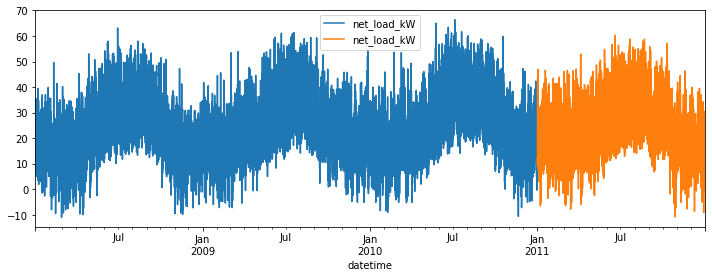

In [13]:
# Plot train and test data
fig, ax = plt.subplots(figsize=(12,4))
df_train[['net_load_kW']].plot(ax=ax, label='Train data')
df_test[['net_load_kW']].plot(ax=ax, label='Test data')
plt.legend()
plt.show()

In [14]:
y_to_train = y.iloc[:(len(y)-365*24)]
y_to_test = y.iloc[(len(y)-365*24):] # last year for testing

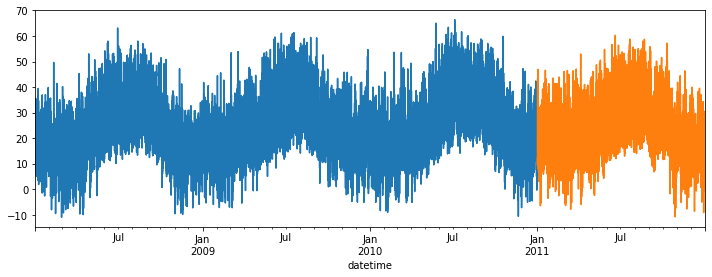

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
y_to_train.plot(ax=ax)
y_to_test.plot(ax=ax)
plt.show()

### Seasonal decomposition (one year period)

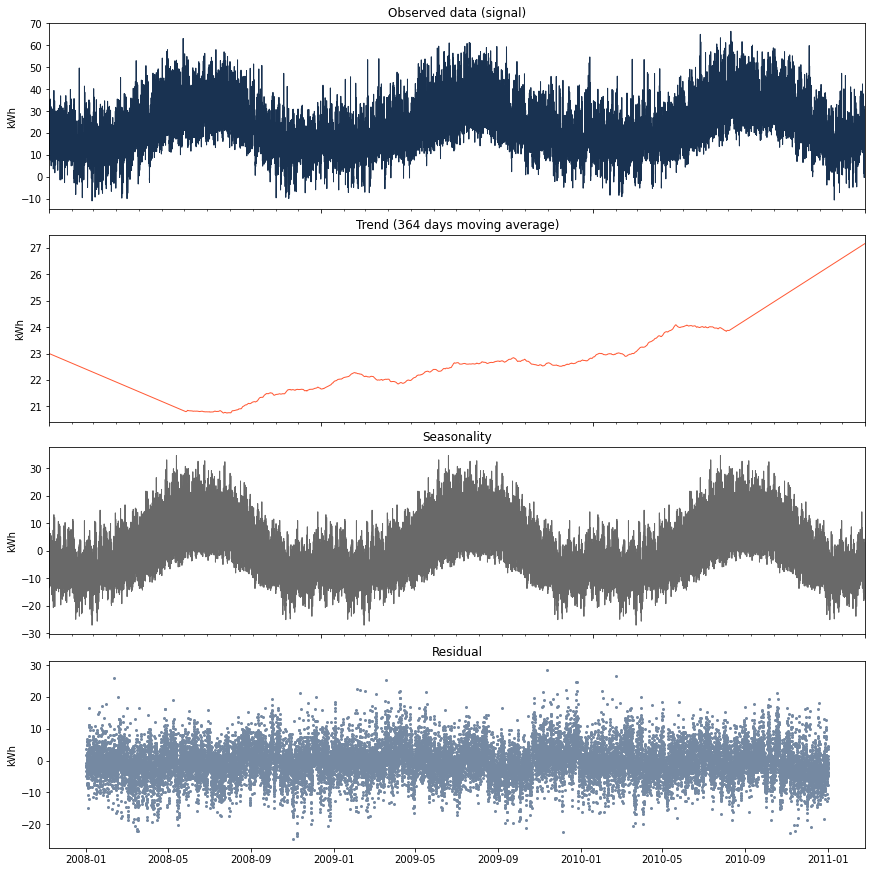

In [16]:
decomp = seasonal_decompose(
    x=y_to_train, 
    model='additive', 
    two_sided=True,
    extrapolate_trend=True,
    period= 24*365)

plot_decomposition(decomp)

### Multiple seasonal decomposition with MSTL

In [ ]:
# mstl = MSTL(y_to_train, periods=(24, 24*7, 24*365), stl_kwargs={"seasonal_deg": 0})
# res = mstl.fit() 

In [ ]:
# # Start with the plot from the results object `res`
# plt.rc("figure", figsize=(10, 14))
# plt.rc("font", size=13)
# fig = res.plot()

### Stationarity test on first difference of train data

In [ ]:
# stationarity_test(y_to_train.diff().dropna())

### ACF and PACF plots

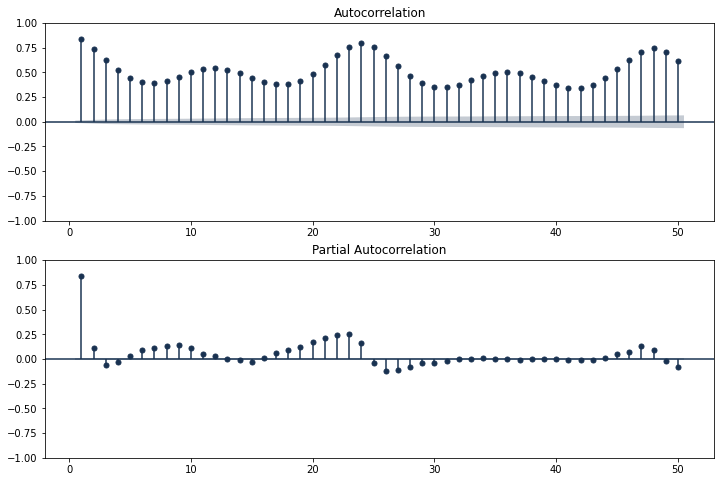

In [23]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(y_to_train, lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_to_train, lags=50, zero=False, ax=ax[1])
plt.show()

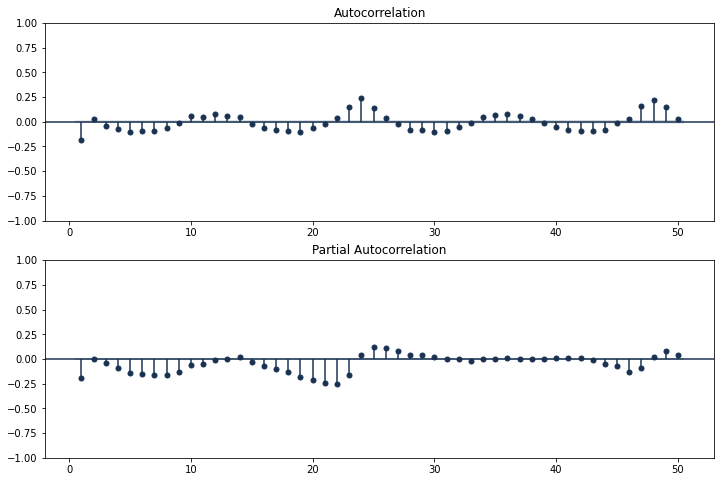

In [24]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(y_to_train.diff().dropna(), lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_to_train.diff().dropna(), lags=50, zero=False, ax=ax[1])
plt.show()

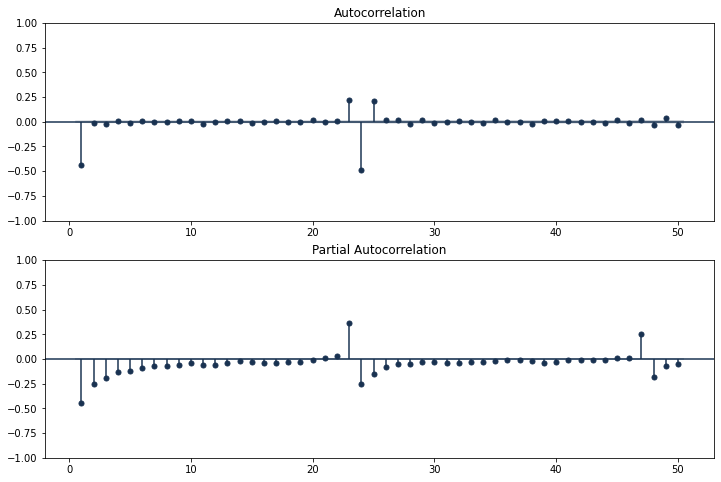

In [25]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(y_to_train.diff().dropna().diff(24).dropna(), lags=50, zero=False, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(y_to_train.diff().dropna().diff(24).dropna(), lags=50, zero=False, ax=ax[1])
plt.show()

### Add fourier terms

In [42]:
# Yearly, weekly and daily seasonality as exogenous variables for SARIMAX model
exog = pd.DataFrame({'date': y.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['year_sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365)
exog['year_cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365)
exog['year_sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365)
exog['year_cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365)
exog['week_sin365'] = np.sin(2 * np.pi * exog.index.dayofweek/7)
exog['week_cos365'] = np.cos(2 * np.pi * exog.index.dayofweek/7)
exog['week_sin365_2'] = np.sin(4 * np.pi * exog.index.dayofweek/7)
exog['week_cos365_2'] = np.cos(4 * np.pi * exog.index.dayofweek/7)
exog['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
exog['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
exog['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
exog['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24) 
exog['outdoor_temp'] = df['outdoor_temp']
exog['outdoor_hum'] = df['outdoor_hum']
exog['diffuse_solar_W_m2'] = df['diffuse_solar_W_m2']
exog['direct_solar_W_m2'] = df['direct_solar_W_m2']
exog = exog.drop(columns=['date'])

### Auto_ARIMA to determine inputs for SARIMAX

Since we represent the hourly, weekly and yearly as Fourier terms, we fit the auto_arima model on only the first three months of the data.

In [ ]:
y_to_train = y.loc['2008-01-02':'2008-03-31']
exog_to_train = exog.loc['2008-01-02':'2008-03-31']

model1 = auto_arima(y=y_to_train, start_p=1, start_q=1,
          max_p=2, max_q=2, d=1, 
          m=24, exogenous=exog_to_train, 
          seasonal=True, stationary=False,
          information_criterion='aic',
          stepwise=True, njobs=-1, trace=True,
          error_action='ignore',
          suppress_warnings=False)

Running auto_arima, the best model that was found was:

```python
Best model:  ARIMA(6,1,1)(0,0,2)[24] intercept
```

However for a similar dataset, [this notebook](https://nbviewer.org/github/pratha19/Springboard_capstone_project_1/blob/master/SDGE_energy_ML.ipynb#6.3) found the best model as:

```python
Best model:  ARIMA(1,1,2)(0,0,2)[24] intercept
```

We will try both sets of parameters for the SARIMAX model.

## SARIMAX

### SARIMAX (6,1,1)(0,0,2,24) model on train data

In [27]:
# Fit model on train data
y_to_train = y.iloc[:(len(y)-365*24)]
y_to_test = y.iloc[(len(y)-365*24):]

# Seasonality as exogenous variables
exog_to_train = exog.iloc[:(len(y)-365*24)]
exog_to_test = exog.iloc[(len(y)-365*24):]

model_train = SARIMAX(df_train['net_load_kW'], order=(6, 1, 1), seasonal_order=(0, 0, 2, 24), exogenous=exog_to_train)

In [28]:
results = model_train.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31983D+00    |proj g|=  2.46832D-01

At iterate    5    f=  3.23728D+00    |proj g|=  2.30985D-02

At iterate   10    f=  3.21216D+00    |proj g|=  2.64028D-02

At iterate   15    f=  3.19515D+00    |proj g|=  5.62592D-02

At iterate   20    f=  3.19071D+00    |proj g|=  1.56569D-02

At iterate   25    f=  3.19011D+00    |proj g|=  4.25826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     29     34      1     0     0   

In [29]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             net_load_kW   No. Observations:                26280
Model:             SARIMAX(6, 1, 1)x(0, 0, [1, 2], 24)   Log Likelihood              -83836.036
Date:                                 Thu, 28 Jul 2022   AIC                         167692.072
Time:                                         11:58:21   BIC                         167773.837
Sample:                                     01-02-2008   HQIC                        167718.474
                                          - 12-31-2010                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4915      0.006     89.000      0.000       0.481       0.502
ar.L2          0.1641      0.006     27.338      0.000       0.152       0.176
ar.L3         -0.0038      0.006     -0.591      0.555      -0.017       0.009
ar.L4         -0.0435      0.007     -6.460      0.000      -0.057      -0.030
ar.L5         -0.0626      0.007     -8.954      0.000      -0.076      -0.049
ar.L6         -0.0346      0.007     -5.235      0.000      -0.048      -0.022
ma.L1         -0.9703      0.002   -518.169      0.000      -0.974      -0.967
ma.S.L24       0.2553      0.005     49.326      0.000       0.245       0.265
ma.S.L48       0.1622      0.005     30.776      0.000       0.152       0.173
sigma2        34.5509      0.238    145.053      0.000      34.084      35.018
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2763.99
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

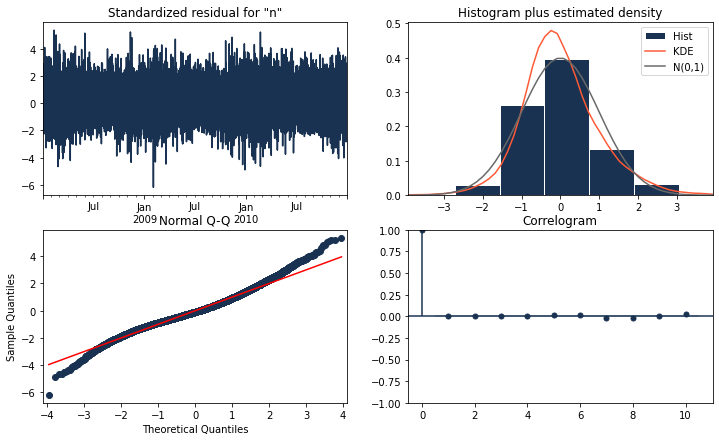

In [30]:
_ = results.plot_diagnostics(figsize=(12, 7))

Mean Absolute Error (SARIMAX) = 4.457
Mean Squared Error (SARIMAX) = 34.563
R2 score (SARIMAX) = 0.759


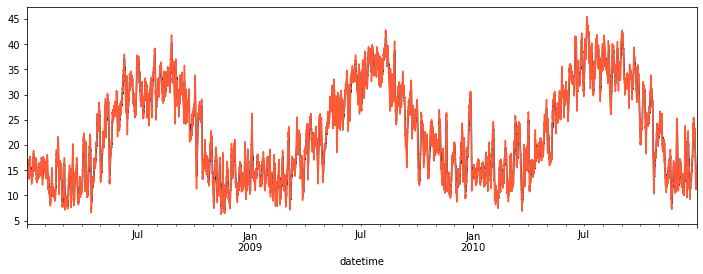

In [31]:
y_pred_train = results.predict()
y_train = df_train['net_load_kW']

fig, ax = plt.subplots(figsize=(12,4))
y_pred_train.rolling(24).mean().plot(ax=ax)
y_train.rolling(24).mean().plot(ax=ax)

mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print(f"Mean Absolute Error (SARIMAX) = {mae.round(3)}")
print(f"Mean Squared Error (SARIMAX) = {mse.round(3)}")
print(f"R2 score (SARIMAX) = {r2.round(3)}")

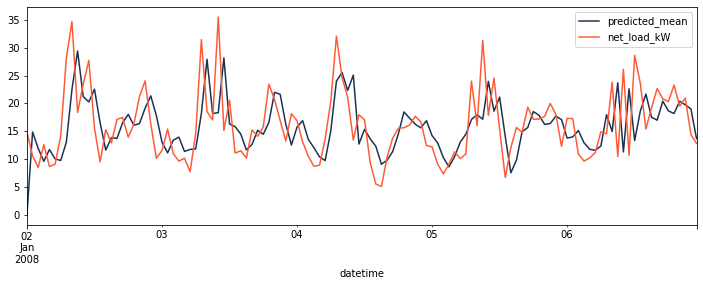

In [36]:
# Examine the prediction for a few days
fig, ax = plt.subplots(figsize=(12,4))
y_pred_train['2008-01-02':'2008-01-06'].plot(ax=ax)
y_train.loc['2008-01-02':'2008-01-06'].plot(ax=ax)
plt.legend()

### SARIMAX (6,1,1)(0,0,2,24) forecast for 8 randomly chosen dates

In [ ]:
days_to_forecast = pd.to_datetime(['2011-09-01 23:00:00', '2011-10-20 23:00:00', 
                                   '2011-01-09 06:00:00', '2011-10-22 21:00:00', 
                                   '2011-06-21 03:00:00', '2011-07-08 02:00:00', 
                                   '2011-08-19 00:00:00', '2011-04-15 07:00:00'])

predictions = list()
for day in days_to_forecast:
  y_to_train = df['net_load_kW'].loc[day+pd.DateOffset(months=-24):day]
  exog_to_train = exog.loc[day+pd.DateOffset(months=-24):day]

  model = SARIMAX(y_to_train, order=(6, 1, 1), seasonal_order=(0, 0, 2, 24), exogenous=exog_to_train)
  model_fit = model.fit()
  output = model_fit.forecast(steps=24)
  predictions.append(output)

In [ ]:

for day_to_plot in range(len(days_to_forecast)):
    
    # Starting the MLFlow run
    #r = mlflow.start_run(run_name="sarimax_(6,1,1)(0,0,2,24)")
    #print("run-uuid:", r.info.run_uuid)

    fig, ax = plt.subplots(figsize=(12,4))
    predictions[day_to_plot].plot()
    df_test['net_load_kW'].loc[(days_to_forecast[day_to_plot]+pd.DateOffset(hours=1)): 
                                days_to_forecast[day_to_plot]+pd.DateOffset(hours=24)].plot()
    plt.legend()
    plt.show()

    y_pred = predictions[day_to_plot]
    y_test = df_test['net_load_kW'].loc[(days_to_forecast[day_to_plot]+pd.DateOffset(hours=1)): 
                                days_to_forecast[day_to_plot]+pd.DateOffset(hours=24)]

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (SARIMAX) = {mae.round(3)}")
    print(f"Mean Squared Error (SARIMAX) = {mse.round(3)}")
    print(f"R2 score (SARIMAX) = {r2.round(3)}")

    ##########
    # MLFLOW #
    ##########
    # for k, v in global_params.items():
    #     mlflow.log_param(k, v)
    #     mlflow.log_param("model", "sarimax")
    #     mlflow.log_param("datetime", days_to_forecast[day_to_plot])
    #     mlflow.log_param("feature", "net_load_kW")
    #     mlflow.log_metric("mse", mse)
    #     mlflow.log_metric("mae", mae)
    #     mlflow.log_metric("r2_score", r2)
    # mlflow.end_run()

### SARIMAX(2, 1, 1)(1, 0, 1, 24) model on train data

In [31]:
# Fit model on train data
y_to_train = y.iloc[:(len(y)-365*24)]
y_to_test = y.iloc[(len(y)-365*24):]

# Seasonality as exogenous variables
exog_to_train = exog.iloc[:(len(y)-365*24)]
exog_to_test = exog.iloc[(len(y)-365*24):]

model_train2 = SARIMAX(df_train['net_load_kW'], order=(2, 1, 1), seasonal_order=(1, 0, 1, 24), exogenous=exog_to_train)

In [32]:
results2 = model_train2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31130D+00    |proj g|=  2.45399D-01


 This problem is unconstrained.



At iterate    5    f=  3.16267D+00    |proj g|=  2.06359D-01

At iterate   10    f=  3.06779D+00    |proj g|=  2.91352D-02

At iterate   15    f=  3.04714D+00    |proj g|=  2.83989D-03

At iterate   20    f=  3.04616D+00    |proj g|=  3.71428D-03

At iterate   25    f=  3.04508D+00    |proj g|=  2.99062D-03

At iterate   30    f=  3.04501D+00    |proj g|=  2.02402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   9.645D-06   3.045D+00
  F =   3.0450139231853384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [20]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        net_load_kW   No. Observations:                26280
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 24)   Log Likelihood              -80022.966
Date:                            Fri, 29 Jul 2022   AIC                         160057.932
Time:                                    22:23:51   BIC                         160106.991
Sample:                                01-02-2008   HQIC                        160073.773
                                     - 12-31-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2927      0.006     47.152      0.000       0.281       0.305
ar.L2          0.1550      0.006     25.812      0.000       0.143       0.167
ma.L1         -0.9286      0.003   -278.197      0.000      -0.935      -0.922
ar.S.L24       0.9973      0.000   2385.982      0.000       0.996       0.998
ma.S.L24      -0.9348      0.002   -439.985      0.000      -0.939      -0.931
sigma2        25.8053      0.162    159.531      0.000      25.488      26.122
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):              4817.09
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

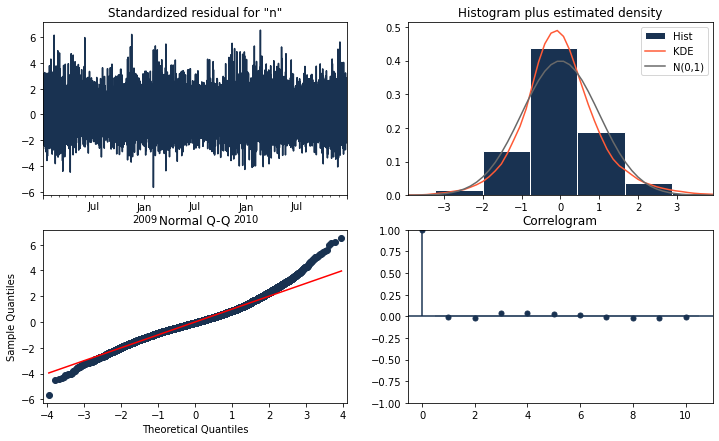

In [33]:
_ = results2.plot_diagnostics(figsize=(12, 7))

Mean Absolute Error (SARIMAX) = 3.783
Mean Squared Error (SARIMAX) = 25.862
R2 score (SARIMAX) = 0.82


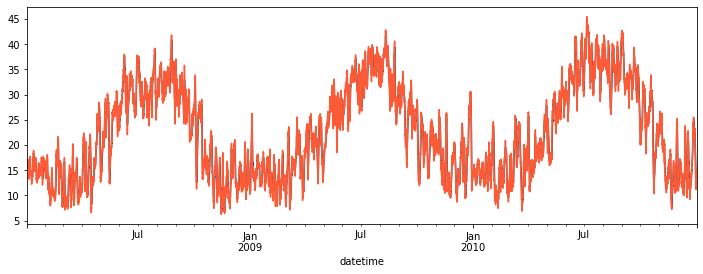

In [34]:
y_pred_train = results2.predict()
y_train = df_train['net_load_kW']

fig, ax = plt.subplots(figsize=(12,4))
y_pred_train.rolling(24).mean().plot(ax=ax)
y_train.rolling(24).mean().plot(ax=ax)

mae = mean_absolute_error(y_train, y_pred_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
print(f"Mean Absolute Error (SARIMAX) = {mae.round(3)}")
print(f"Mean Squared Error (SARIMAX) = {mse.round(3)}")
print(f"R2 score (SARIMAX) = {r2.round(3)}")

<AxesSubplot:xlabel='datetime'>

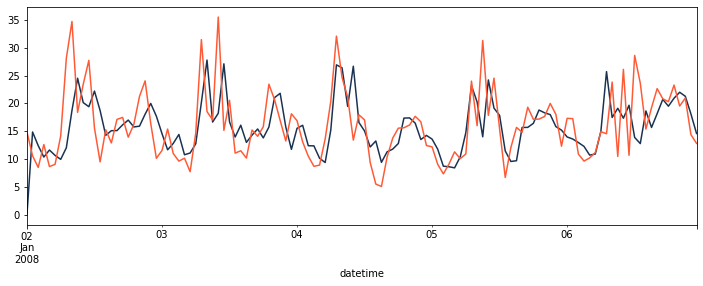

In [35]:
# Examine the prediction for a few days
fig, ax = plt.subplots(figsize=(12,4))
y_pred_train['2008-01-02':'2008-01-06'].plot(ax=ax)
y_train.loc['2008-01-02':'2008-01-06'].plot(ax=ax)

### SARIMAX(2,1,1)(1,0,1,24) forecast for 8 randomly chosen dates

In [43]:
days_to_forecast = pd.to_datetime(['2011-09-01 23:00:00', '2011-10-20 23:00:00', 
                                   '2011-01-09 06:00:00', '2011-10-22 21:00:00', 
                                   '2011-06-21 03:00:00', '2011-07-08 02:00:00', 
                                   '2011-08-19 00:00:00', '2011-04-15 07:00:00'])

predictions = list()
for day in days_to_forecast:
  y_to_train = df['net_load_kW'].loc[day+pd.DateOffset(months=-24):day]
  exog_to_train = exog.loc[day+pd.DateOffset(months=-24):day]

  model = SARIMAX(y_to_train, order=(2, 1, 1), seasonal_order=(1, 0, 1, 24), exogenous=exog_to_train)
  model_fit = model.fit()
  output = model_fit.forecast(steps=24)
  predictions.append(output)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33625D+00    |proj g|=  2.57312D-01


 This problem is unconstrained.



At iterate    5    f=  3.20838D+00    |proj g|=  1.79449D-01

At iterate   10    f=  3.08953D+00    |proj g|=  5.26386D-02

At iterate   15    f=  3.07809D+00    |proj g|=  5.89908D-03

At iterate   20    f=  3.07626D+00    |proj g|=  1.47857D-02

At iterate   25    f=  3.07537D+00    |proj g|=  3.00522D-03

At iterate   30    f=  3.07535D+00    |proj g|=  1.77861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     37      1     0     0   1.161D-05   3.075D+00
  F =   3.0753488842483483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33959D+00    |proj g|=  2.57687D-01

At iterate    5    f=  3.21043D+00    |proj g|=  1.83245D-01

At iterate   10    f=  3.09634D+00    |proj g|=  6.05797D-02

At iterate   15    f=  3.08063D+00    |proj g|=  7.34700D-03

At iterate   20    f=  3.07821D+00    |proj g|=  2.15531D-03

At iterate   25    f=  3.07817D+00    |proj g|=  3.47327D-04

At iterate   30    f=  3.07817D+00    |proj g|=  8.54841D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  3.18433D+00    |proj g|=  1.97768D-01

At iterate   10    f=  3.08090D+00    |proj g|=  3.76077D-02

At iterate   15    f=  3.05956D+00    |proj g|=  3.48456D-03

At iterate   20    f=  3.05827D+00    |proj g|=  1.03652D-02

At iterate   25    f=  3.05749D+00    |proj g|=  3.63898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     31      1     0     0   2.691D-06   3.057D+00
  F =   3.0574913361804339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  3.20972D+00    |proj g|=  1.84011D-01

At iterate   10    f=  3.09530D+00    |proj g|=  5.23147D-02

At iterate   15    f=  3.08051D+00    |proj g|=  4.30209D-03

At iterate   20    f=  3.07851D+00    |proj g|=  1.43477D-02

At iterate   25    f=  3.07831D+00    |proj g|=  5.59546D-04

At iterate   30    f=  3.07826D+00    |proj g|=  3.58032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     36      1     0     0   1.996D-05   3.078D+00
  F =   3.0782636609162237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.20386D+00    |proj g|=  1.88624D-01

At iterate   10    f=  3.08806D+00    |proj g|=  3.32985D-02

At iterate   15    f=  3.07678D+00    |proj g|=  3.83008D-03

At iterate   20    f=  3.07501D+00    |proj g|=  2.54634D-03

At iterate   25    f=  3.07467D+00    |proj g|=  8.21313D-04

At iterate   30    f=  3.07465D+00    |proj g|=  3.07283D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     34      1     0     0   3.073D-05   3.075D+00
  F =   3.0746512515563489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33554D+00    |proj g|=  2.54654D-01

At iterate    5    f=  3.20277D+00    |proj g|=  1.89521D-01

At iterate   10    f=  3.08916D+00    |proj g|=  3.36727D-02

At iterate   15    f=  3.07635D+00    |proj g|=  2.46166D-03

At iterate   20    f=  3.07493D+00    |proj g|=  3.83945D-03

At iterate   25    f=  3.07426D+00    |proj g|=  3.10057D-03

At iterate   30    f=  3.07422D+00    |proj g|=  2.61038D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  3.20837D+00    |proj g|=  1.77157D-01

At iterate   10    f=  3.09210D+00    |proj g|=  6.04030D-02

At iterate   15    f=  3.07736D+00    |proj g|=  6.29597D-03

At iterate   20    f=  3.07666D+00    |proj g|=  1.78560D-02

At iterate   25    f=  3.07504D+00    |proj g|=  6.33624D-04

At iterate   30    f=  3.07497D+00    |proj g|=  1.72033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     37      1     0     0   1.753D-05   3.075D+00
  F =   3.0749717585310816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.20092D+00    |proj g|=  1.81359D-01

At iterate   10    f=  3.08686D+00    |proj g|=  4.86317D-02

At iterate   15    f=  3.07287D+00    |proj g|=  3.96774D-03

At iterate   20    f=  3.07125D+00    |proj g|=  1.66733D-02

At iterate   25    f=  3.07059D+00    |proj g|=  1.55077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     33      1     0     0   8.139D-06   3.071D+00
  F =   3.0705834365375910     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


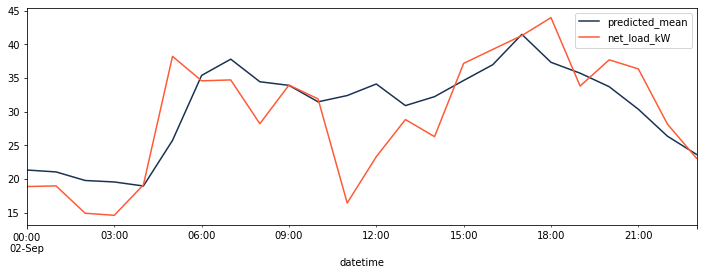

Mean Absolute Error (SARIMAX) = 4.096
Mean Squared Error (SARIMAX) = 32.923
Root Mean Squared Error (SARIMAX) = 5.737856742721973
R2 score (SARIMAX) = 0.566


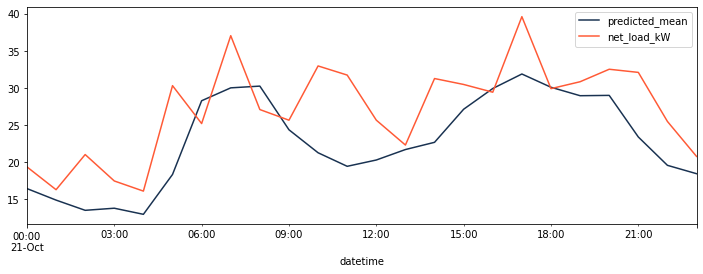

Mean Absolute Error (SARIMAX) = 4.913
Mean Squared Error (SARIMAX) = 37.488
Root Mean Squared Error (SARIMAX) = 6.122744482664617
R2 score (SARIMAX) = 0.037


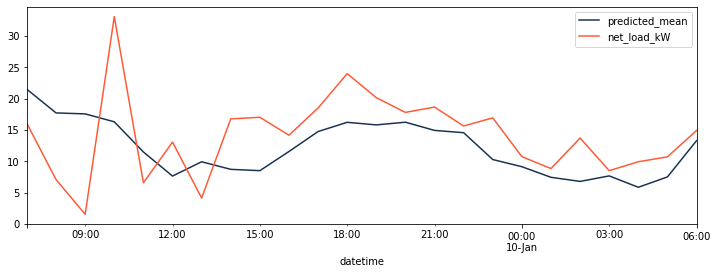

Mean Absolute Error (SARIMAX) = 5.533
Mean Squared Error (SARIMAX) = 47.961
Root Mean Squared Error (SARIMAX) = 6.92538807576875
R2 score (SARIMAX) = -0.104


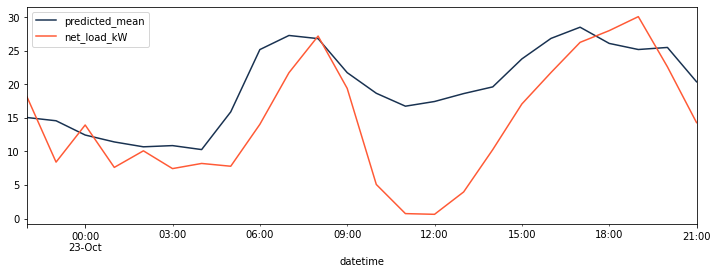

Mean Absolute Error (SARIMAX) = 6.181
Mean Squared Error (SARIMAX) = 61.687
Root Mean Squared Error (SARIMAX) = 7.854107205787301
R2 score (SARIMAX) = 0.166


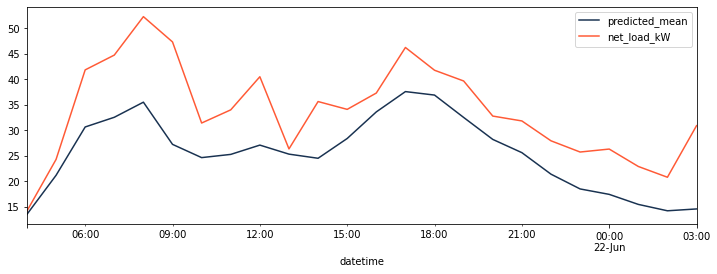

Mean Absolute Error (SARIMAX) = 8.296
Mean Squared Error (SARIMAX) = 91.403
Root Mean Squared Error (SARIMAX) = 9.560491619158505
R2 score (SARIMAX) = -0.087


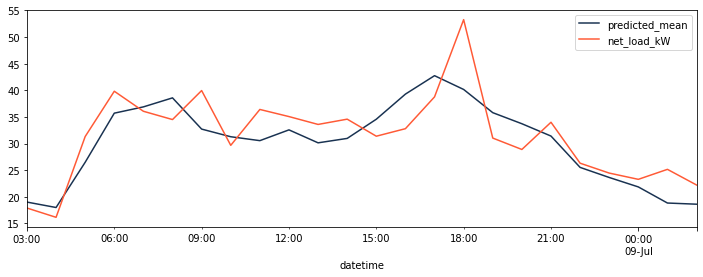

Mean Absolute Error (SARIMAX) = 3.872
Mean Squared Error (SARIMAX) = 22.12
Root Mean Squared Error (SARIMAX) = 4.703190406521939
R2 score (SARIMAX) = 0.635


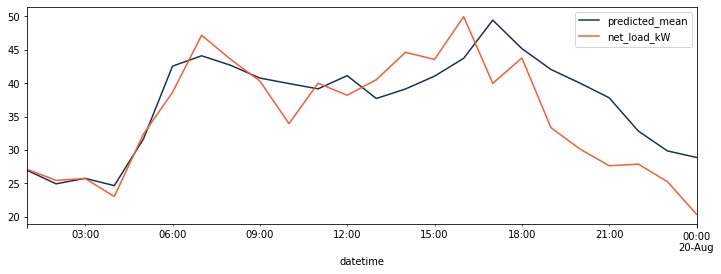

Mean Absolute Error (SARIMAX) = 3.992
Mean Squared Error (SARIMAX) = 26.808
Root Mean Squared Error (SARIMAX) = 5.1776442519740575
R2 score (SARIMAX) = 0.609


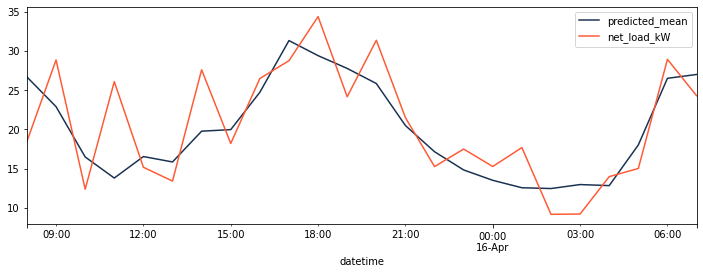

Mean Absolute Error (SARIMAX) = 3.799
Mean Squared Error (SARIMAX) = 21.278
Root Mean Squared Error (SARIMAX) = 4.612808255282242
R2 score (SARIMAX) = 0.582


In [44]:
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])

pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

for day_to_plot in range(len(days_to_forecast)):

    day = days_to_forecast[day_to_plot]
    index = pred_indices[day_to_plot]

    # Starting the MLFlow run
    #r = mlflow.start_run(run_name="sarimax_(2,1,1)(1,0,1,24)")
    #print("run-uuid:", r.info.run_uuid)

    fig, ax = plt.subplots(figsize=(12,4))
    predictions[day_to_plot].plot()
    df_test['net_load_kW'].loc[(days_to_forecast[day_to_plot]+pd.DateOffset(hours=1)): 
                                days_to_forecast[day_to_plot]+pd.DateOffset(hours=24)].plot()
    plt.legend()
    plt.show()

    y_pred = predictions[day_to_plot]
    y_test = df_test['net_load_kW'].loc[(days_to_forecast[day_to_plot]+pd.DateOffset(hours=1)): 
                                days_to_forecast[day_to_plot]+pd.DateOffset(hours=24)]

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Absolute Error (SARIMAX) = {mae.round(3)}")
    print(f"Mean Squared Error (SARIMAX) = {mse.round(3)}")
    print(f"Root Mean Squared Error (SARIMAX) = {np.sqrt(mse.round(3))}")
    print(f"R2 score (SARIMAX) = {r2.round(3)}")

    # ##########
    # # MLFLOW #
    # ##########
    # for k, v in global_params.items():
    #     mlflow.log_param(k, v)
    #     mlflow.log_param("model", "sarimax")
    #     mlflow.log_param("datetime", days_to_forecast[day_to_plot])
    #     mlflow.log_param("feature", "net_load_kW")
    #     mlflow.log_metric("mse", mse)
    #     mlflow.log_metric("mae", mae)
    #     mlflow.log_metric("r2_score", r2)
    # mlflow.end_run()

    # ##########
    # # SQL DB #
    # ##########
    # day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    # day_forecast['prediction'] = y_pred
    # day_forecast['run_id'] = r.info.run_uuid
    # day_forecast['id'] = np.arange(index+1,index+25)
    # forecasts = pd.concat([forecasts, day_forecast], axis=0)

forecasts = forecasts.set_index('id')
#forecasts.to_sql("forecast", con=db, if_exists="append")